Data science & engineering are **multi‑disciplinary**. We will face many domains: finance, health, e‑commerce, **sports**.  
Our job is to **adapt**, build a clean data pipeline, and turn data into **useful decisions**.

In this project, we will use **live EuroLeague data** from the current season to help two Istanbul clubs improve.  
We will fetch real data, compute team metrics, compare against the league, and build a clear chart for coaches.

### Scenario
We are the analytics team at a sports club. Our two EuroLeague teams need your help:
- **ULK = Fenerbahçe Beko**
- **IST = Anadolu Efes**

Both started the season below expectations. Your task: find **where they lag** (vs League / Best team) and **what to fix**.

### What we will practice
- **Data engineering:** call a web API, handle errors/timeouts, combine many games.  
- **Pandas analytics:** group, aggregate, compute per‑match statistics.  
- **Visualization:** make a clear **matplotlib** chart with the correct colors.  
- **Communication:** short, coach‑ready notes with specific actions.


## What is the EuroLeague Live API?

We will use a simple, public HTTP endpoint that returns **JSON play-by-play / shot events**.
This API returns shot-by-shot rows for a single game. You ask for a game using its official EuroLeague game code.
Every match has one unique gamecode.

**Base endpoint**
```
https://live.euroleague.net/api/Points
```

**Required query parameters**
- `gamecode` — integer code of the game (e.g., 1, 2, …).
- `seasoncode` — competition + year (e.g., `E2025` for EuroLeague 2025).

**Example**
```
GET https://live.euroleague.net/api/Points?gamecode=30&seasoncode=E2025
```

**Typical JSON shape**
```json
{
  "Rows": [
    {
      "TEAM": "ULK",
      "PLAYER": "John Doe",
      "ACTION": "THREE POINTER",
      "POINTS": 3,
      "FASTBREAK": 0,
      "SECOND_CHANCE": 0,
      "COORD_X": 72.3,
      "COORD_Y": 14.7,
      "GAME_CODE": 30,        // we also add this client-side
      "SEASON_CODE": "E2025"  // we also add this client-side
    },
    ...
  ]
}
```

> Notes:
> - Only **made** shots carry points (e.g., `"THREE POINTER"`, `"TWO POINTER"`). Missed shots use `"MISSED ..."` actions and have 0 points.
> - Some useful boolean flags: `FASTBREAK`, `SECOND_CHANCE` (treated as 0/1, so cast to integers).
> - You will **normalize** `TEAM` codes to uppercase/trim for reliable grouping.

**Reliability tips**
- Use a small delay between calls (e.g., `time.sleep(0.25)`) to be polite.
- Wrap requests in `try/except`; handle JSON decode errors and empty games.
- Always add `GAME_CODE` and `SEASON_CODE` columns on the dataframes while fetching the data from the api.
- Check for the column values and types. Clean and fix if any column has bad data.




---
## Part 1 — Collecting Data from the API (API → DataFrame) **(40p)**

**Goal:** We will fetch the first 35 games of the season and create a pandas datafarame.
**Requirements:**
- Use `requests` with timeout and error handling.  
- Add `GAME_CODE` and `SEASON_CODE`.  
- Normalize `TEAM` (uppercase + trim).  
- Output a single DataFrame: `all_games_df`.
- The shape of our final dataframe should be (5602, 20)



In [ ]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import json

In [ ]:
# In this cell, we are checking how API works and what does it return before working on the project
base_url = "https://live.euroleague.net/api/Points"
season_code = "E2025"
try:
    print("API columns are getting checked (Game 30)...")
    test_params = {"gamecode": 30, "seasoncode": season_code} # just any value that was put to check the API responses in advance
    test_response = requests.get(base_url, params=test_params, timeout=10)
    test_response.raise_for_status()
    test_data = test_response.json()
    if test_data['Rows']:
        test_df = pd.DataFrame(test_data['Rows'])
        print(f"Columns returned from API for Game 30: {test_df.columns.tolist()}")
except Exception as e: # if there is any error
    print(f"Error when checking columns: {e}")

API columns are getting checked (Game 30)...
Columns returned from API for Game 30: ['NUM_ANOT', 'TEAM', 'ID_PLAYER', 'PLAYER', 'ID_ACTION', 'ACTION', 'POINTS', 'COORD_X', 'COORD_Y', 'ZONE', 'FASTBREAK', 'SECOND_CHANCE', 'POINTS_OFF_TURNOVER', 'MINUTE', 'CONSOLE', 'POINTS_A', 'POINTS_B', 'UTC']


In [ ]:
all_games_data = [] # List for storing DataFrames of every single game

for game_code in range(1, 36): # First 35 games must we take
    params = {
        "gamecode": game_code,
        "seasoncode": season_code
    }

    try:
        response = requests.get(base_url, params=params, timeout=10) # we add timeout so that we don't wait for so long
        response.raise_for_status()
        data = response.json()

        if data['Rows']:
            game_df = pd.DataFrame(data['Rows'])

            game_df['GAME_CODE'] = game_code
            game_df['SEASON_CODE'] = season_code

            # Normalizing Team Code(uppercase + trim)
            game_df['TEAM'] = game_df["TEAM"].astype(str).str.strip().str.upper()

            # Replacing "," with "" for names
            if "PLAYER" in game_df.columns:
                 game_df['PLAYER'] = game_df['PLAYER'].str.replace(',', '')
            # In case name is null
            else:
                 game_df['PLAYER'] = 'Unknown'

            # turning Fast break and second chance columns into integer(just in case)
            if 'FASTBREAK' in game_df.columns:
                game_df['FASTBREAK'] = game_df['FASTBREAK'].astype(int)
            if 'SECOND_CHANCE' in game_df.columns:
                 game_df['SECOND_CHANCE'] = game_df['SECOND_CHANCE'].astype(int)

            # collect all columns taken from API
            all_games_data.append(game_df)
            print(f"Game {game_code} is processed successfully. Row amount: {len(game_df)}")
        else:
            print(f"There is no data for Game {game_code} or 'Rows' is empty.")

    except requests.exceptions.Timeout:
        print(f"Error: The request for game {game_code} timed out.")
    except requests.exceptions.RequestException as e:
        print(f"Error: An error occurred during the request for game {game_code}: {e}")
    except json.JSONDecodeError:
        print(f"Error: The response received for game {game_code} is not in JSON format.")
    except Exception as e:
        print(f"Error: An unexpected error occurred while processing game {game_code}: {e}")

    time.sleep(0.25)

if all_games_data:
    all_games_df = pd.concat(all_games_data, ignore_index=True)
    print("\nALL Game Data Combined Successfully.")
    print(f"DataFrame Shape: {all_games_df.shape}") # Controlling dataframe shape
    print("\nDataFrame Columns:")
    print(all_games_df.columns.tolist())

else:
    print("\nNo game data has taken from API. DataFrame could not created.")
    all_games_df = pd.DataFrame()

Game 1 is processed successfully. Row amount: 158
Game 2 is processed successfully. Row amount: 188
Game 3 is processed successfully. Row amount: 146
Game 4 is processed successfully. Row amount: 153
Game 5 is processed successfully. Row amount: 155
Game 6 is processed successfully. Row amount: 160
Game 7 is processed successfully. Row amount: 142
Game 8 is processed successfully. Row amount: 162
Game 9 is processed successfully. Row amount: 154
Game 10 is processed successfully. Row amount: 164
Game 11 is processed successfully. Row amount: 151
Game 12 is processed successfully. Row amount: 136
Game 13 is processed successfully. Row amount: 164
Game 14 is processed successfully. Row amount: 167
Game 15 is processed successfully. Row amount: 188
Game 16 is processed successfully. Row amount: 160
Game 17 is processed successfully. Row amount: 164
Game 18 is processed successfully. Row amount: 184
Game 19 is processed successfully. Row amount: 170
Game 20 is processed successfully. Row a

In [ ]:
all_games_df.head() # seeing our dataframe in total

,NUM_ANOT,TEAM,ID_PLAYER,PLAYER,ID_ACTION,ACTION,POINTS,COORD_X,COORD_Y,ZONE,FASTBREAK,SECOND_CHANCE,POINTS_OFF_TURNOVER,MINUTE,CONSOLE,POINTS_A,POINTS_B,UTC,GAME_CODE,SEASON_CODE
0,4,IST,P014102,JONES KAI,2FGM,Two Pointer,2,-12,-6,A,0,0,0,1,09:39,2,0,20250930174549,1,E2025
1,8,IST,P007200,LARKIN SHANE,3FGA,Missed Three Pointer,0,414,602,I,0,0,0,1,09:11,2,0,20250930174617,1,E2025
2,11,IST,P012710,OSMANI ERCAN,2FGM,Two Pointer,2,-307,0,D,0,1,1,2,08:57,4,0,20250930174631,1,E2025
3,12,TEL,P011219,SORKIN ROMAN,2FGM,Two Pointer,2,-81,125,B,0,0,0,2,08:42,4,2,20250930174647,1,E2025
4,16,TEL,P011219,SORKIN ROMAN,FTM,Free Throw In,1,-1,-1,,0,0,0,2,08:42,4,3,20250930174714,1,E2025


In [ ]:
all_games_df.info() # having info about columns and dataframe itself

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5602 entries, 0 to 5601
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   NUM_ANOT             5602 non-null   int64 
 1   TEAM                 5602 non-null   object
 2   ID_PLAYER            5602 non-null   object
 3   PLAYER               5602 non-null   object
 4   ID_ACTION            5602 non-null   object
 5   ACTION               5602 non-null   object
 6   POINTS               5602 non-null   int64 
 7   COORD_X              5602 non-null   int64 
 8   COORD_Y              5602 non-null   int64 
 9   ZONE                 5602 non-null   object
 10  FASTBREAK            5602 non-null   int64 
 11  SECOND_CHANCE        5602 non-null   int64 
 12  POINTS_OFF_TURNOVER  5602 non-null   object
 13  MINUTE               5602 non-null   int64 
 14  CONSOLE              5602 non-null   object
 15  POINTS_A             5602 non-null   int64 
 16  POINTS


---
## Part 2 — Teams vs League vs Best **(30p)**

We will compare **ULK = Fenerbahçe Beko** and **IST = Anadolu Efes** with **League Avg** and **Best team**. See how our teams are doing comparing to league average and the best team in that specific metric. The below metrics should be calculated for our teams, as average and for the best team in that specific metrics.

**What are we reporting ?**
1. **Points scored per game** (higher is better)
   - *How productive the offense is.*
   - How it’s computed: Sum of a team’s points in each game → average across games.
   - League Avg = mean of teams’ **per‑game means**.
2. **Points conceded per game** (lower is better)
   - *How solid the defence is.*
   - How it’s computed: Total points in the game minus the team’s points → average across games.
3. **Points from 3-pointers** (per game)
   - *Contribution from long-range shots; hints at a perimeter-oriented style.*
   - How it’s computed: Sum of points when ACTION == "THREE POINTER" → per-game average.
4. **Points from 3-pointers** (per game)
   - *Contribution from drives/inside/2-point finishes; hints at a inside style.*
   - How it’s computed: Sum of points when ACTION == "TWO POINTER" → per-game average.
5. **Fast-break points** (per game) (often good to be higher)
   - *'Easy' points from running in transition*
   - How it’s computed: Sum of points where FASTBREAK == 1 → per-game average.

**Why these 5?**  Offense (scored), defense (conceded), style (3-pt vs 2-pt mix), and easy points (fast break). They tell the story without advanced stats.

In [ ]:
# Check if the DataFrame is blank or not before continuing
if not all_games_df.empty:

    # 1. Score per Match
    scored_per_game = all_games_df.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum().reset_index()
    avg_scored_per_team = scored_per_game.groupby('TEAM')['POINTS'].mean().reset_index().rename(columns={'POINTS': 'Score per match'})

    # 2. Points Conceded per Match
    total_points_per_game = scored_per_game.groupby('GAME_CODE')['POINTS'].sum().reset_index().rename(columns={'POINTS': 'TOTAL_POINTS'})
    scores_merged = pd.merge(scored_per_game, total_points_per_game, on='GAME_CODE')
    scores_merged['Points Conceded'] = scores_merged['TOTAL_POINTS'] - scores_merged['POINTS']
    avg_conceded_per_team = scores_merged.groupby('TEAM')['Points Conceded'].mean().reset_index().rename(columns={'Points Conceded': 'Points condeded per match'})

    # 3. 3PT points per match
    three_pointers_df = all_games_df[all_games_df['ACTION'] == 'Three Pointer'].copy()
    three_pointers_per_game = three_pointers_df.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum().reset_index()
    all_match_teams = all_games_df[['GAME_CODE', 'TEAM']].drop_duplicates()
    three_pointers_per_game_full = pd.merge(all_match_teams, three_pointers_per_game, on=['GAME_CODE', 'TEAM'], how='left').fillna(0)
    avg_3pt_per_team = three_pointers_per_game_full.groupby('TEAM')['POINTS'].mean().reset_index().rename(columns={'POINTS': '3PT points per match'})

    # 4. 2PT points per match
    two_pointers_df = all_games_df[all_games_df['ACTION'] == 'Two Pointer'].copy()
    two_pointers_per_game = two_pointers_df.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum().reset_index()
    two_pointers_per_game_full = pd.merge(all_match_teams, two_pointers_per_game, on=['GAME_CODE', 'TEAM'], how='left').fillna(0)
    avg_2pt_per_team = two_pointers_per_game_full.groupby('TEAM')['POINTS'].mean().reset_index().rename(columns={'POINTS': '2PT points per match'})

    # 5. Fast Break points per match
    fast_break_df = all_games_df[all_games_df['FASTBREAK'] == 1].copy()
    fast_break_per_game = fast_break_df.groupby(['GAME_CODE', 'TEAM'])['POINTS'].sum().reset_index()
    fast_break_per_game_full = pd.merge(all_match_teams, fast_break_per_game, on=['GAME_CODE', 'TEAM'], how='left').fillna(0)
    avg_fb_per_team = fast_break_per_game_full.groupby('TEAM')['POINTS'].mean().reset_index().rename(columns={'POINTS': 'Fast Break points per match'})

    # Merging all metrics
    team_metrics = pd.merge(avg_scored_per_team, avg_conceded_per_team, on='TEAM', how='outer')
    team_metrics = pd.merge(team_metrics, avg_3pt_per_team, on='TEAM', how='outer')
    team_metrics = pd.merge(team_metrics, avg_2pt_per_team, on='TEAM', how='outer')
    team_metrics = pd.merge(team_metrics, avg_fb_per_team, on='TEAM', how='outer')

    # filling NaN with 0
    team_metrics = team_metrics.fillna(0)

    # Calculating league averages
    league_avg = team_metrics.drop(columns=['TEAM']).mean()
    league_avg['TEAM'] = 'League AVG' # League average for comparison

    # Finding best teams in league
    best_teams = {}
    metrics_to_compare = ['Score per match', 'Points condeded per match', '3PT points per match', '2PT points per match', 'Fast Break points per match']

    best_teams['Score per match'] = team_metrics.loc[team_metrics['Score per match'].idxmax()]
    best_teams['Points condeded per match'] = team_metrics.loc[team_metrics['Points condeded per match'].idxmin()]
    best_teams['3PT points per match'] = team_metrics.loc[team_metrics['3PT points per match'].idxmax()]
    best_teams['2PT points per match'] = team_metrics.loc[team_metrics['2PT points per match'].idxmax()]
    best_teams['Fast Break points per match'] = team_metrics.loc[team_metrics['Fast Break points per match'].idxmax()]

    # taking ULK & IST data
    ulk_metrics = team_metrics[team_metrics['TEAM'] == 'ULK'].iloc[0] if 'ULK' in team_metrics['TEAM'].values else pd.Series(0, index=team_metrics.columns, name='ULK')
    ist_metrics = team_metrics[team_metrics['TEAM'] == 'IST'].iloc[0] if 'IST' in team_metrics['TEAM'].values else pd.Series(0, index=team_metrics.columns, name='IST')

    # We configure the data here before comparison
    comparison_data = {}
    best_team_values = {}
    best_team_codes = {}

    for metric in metrics_to_compare:
        comparison_data[metric] = {
            'ULK': ulk_metrics.get(metric, 0),
            'IST': ist_metrics.get(metric, 0),
            'League AVG': league_avg.get(metric, 0),
            'Best Team': best_teams[metric].get(metric, 0)
        }
        best_team_values[metric] = best_teams[metric].get(metric, 0)
        best_team_codes[metric] = best_teams[metric].get('TEAM', 'N/A')

    comparison_df = pd.DataFrame(comparison_data)
    print("\nComparison Data:")
    print(comparison_df)

else:
    print("\nError: Could not operate the process.")
    comparison_df = pd.DataFrame() # Empty DataFrame
    best_team_codes = {}


Comparison Data:
            Score per match  Points condeded per match  3PT points per match  \
ULK               81.750000                  85.000000                26.250   
IST               83.750000                  84.000000                28.500   
League AVG        86.129167                  86.075000                27.725   
Best Team         97.500000                  74.333333                37.000   

            2PT points per match  Fast Break points per match  
ULK                    38.500000                    13.000000  
IST                    38.500000                     4.250000  
League AVG             41.950000                     9.029167  
Best Team              53.333333                    22.333333  



---
## Part 3 — Visualization (Grouped Bar Chart) **(15p)**

We will make one grouped bar chart that visualizes the five metrics from Part 2 (x-axis = metrics).
For each metric, plot four bars. **Colors:** ULK (yellow), IST (blue), League Avg (orange), Best Team (green).

Requirements:

- Title: “Team vs League vs Best (per match)”

- X-axis: the five metric names from Part 2, in the same order.

- Y-axis: label as “Per-match value”; values must match Part 2 (same aggregation).

- Colors: ULK = yellow, IST = blue, League = orange, Best = green (consistent across all metrics).

- Best label: write the team code above each green bar (e.g., “BAR”, “MAD”).

- Value labels: show the number on or above each bar (rounded to 1 decimal).

- Legend: ULK, IST, League AVG, Best team.

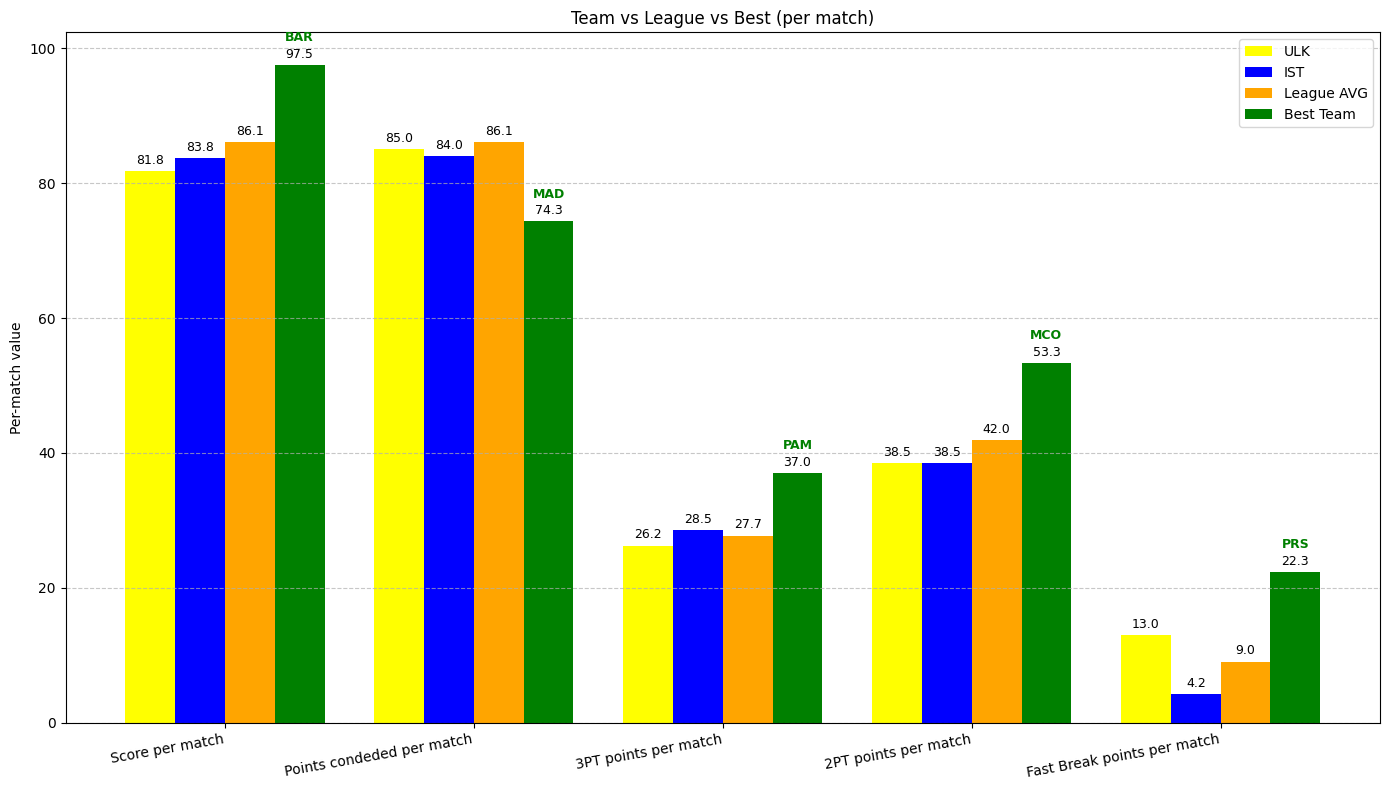

In [ ]:
if not comparison_df.empty:
    metrics_list = comparison_df.columns.tolist() # Metric list

    ulk_values = comparison_df.loc['ULK'].values
    ist_values = comparison_df.loc['IST'].values
    league_avg_values = comparison_df.loc['League AVG'].values
    best_team_values_list = comparison_df.loc['Best Team'].values

    x = np.arange(len(metrics_list))
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 8)) # Adjusting graphic size

    # Drawing bars, also indicating the color
    rects1 = ax.bar(x - 1.5*width, ulk_values, width, label='ULK', color='yellow')
    rects2 = ax.bar(x - 0.5*width, ist_values, width, label='IST', color='blue')
    rects3 = ax.bar(x + 0.5*width, league_avg_values, width, label='League AVG', color='orange')
    rects4 = ax.bar(x + 1.5*width, best_team_values_list, width, label='Best Team', color='green')

    # Adjusting title, metrics and rotation of them
    ax.set_ylabel('Per-match value')
    ax.set_title('Team vs League vs Best (per match)')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_list, rotation=10, ha='right')
    ax.legend() # creating a legend that shows the color of classes

    # This function adds labels on top of bars
    def autolabel(rects, is_best=False, best_codes=None):
        for i, rect in enumerate(rects):
            height = rect.get_height()
            label_text = f'{height:.1f}'
            ax.annotate(label_text,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
            # Operate the best team in here
            if is_best and best_codes:
                metric_name = metrics_list[i]
                team_code = best_codes.get(metric_name, '')
                ax.annotate(team_code,
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 15),
                            textcoords="offset points",
                            ha='center', va='bottom', fontsize=9, color='green', weight='bold')


    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4, is_best=True, best_codes=best_team_codes)

    fig.tight_layout() # For a better visualization
    plt.grid(axis='y', linestyle='--', alpha=0.7) # Adding grid to the background
    plt.show() # show the whole graph

else:
     print("\nError: Could not operate the process.")


---
## Part 4 — Player Recommendation **(15p)**

From Part 2 and Part 3, we found that IST’s points from 3s per game are above the league average, while ULK’s are below. We focus on a single, concrete fix: lift ULK’s 3-point offense with one clear player profile from the all league players.

We need to find a sharp-shooter player candidate. Select (Recommend) top 5 candidate (sort descending by 3PT points per game), (not currently on **ULK**):
- 3PT points per game ≥ 6.0

- **Output:** Top 5 player name, their team, 3PT points per game

In [ ]:
if not all_games_df.empty and 'ACTION' in all_games_df.columns:
    # filtering the players who has 3PT
    three_pointers_players = all_games_df[all_games_df['ACTION'] == 'Three Pointer'].copy()

    # Calculate total 3PT point per player
    total_3pt_points_per_player = three_pointers_players.groupby(['PLAYER', 'TEAM'])['POINTS'].sum().reset_index()

    # Calculate total match played per player
    games_played_per_player = all_games_df.groupby(['PLAYER', 'TEAM'])['GAME_CODE'].nunique().reset_index().rename(columns={'GAME_CODE': 'Games Played'})

    # Merge two data, doing this after performing operations on these two data provides better and easier data manipulation
    player_3pt_stats = pd.merge(total_3pt_points_per_player, games_played_per_player, on=['PLAYER', 'TEAM'], how='left')

    # Filter players who doesn't have 3PT
    player_3pt_stats = player_3pt_stats[player_3pt_stats['Games Played'] > 0]

    # Calculate 3PT average per match
    player_3pt_stats['3PT Points Per Game'] = player_3pt_stats['POINTS'] / player_3pt_stats['Games Played']

    # We want players different from ULK and has >=6 point per game
    candidate_players = player_3pt_stats[
        (player_3pt_stats['TEAM'] != 'ULK') &
        (player_3pt_stats['3PT Points Per Game'] >= 6.0)
    ].copy()

    # Sort results by points per game in descending order and take top 5
    top_5_candidates = candidate_players.sort_values(by='3PT Points Per Game', ascending=False).head(5)

    print("\nThree Pointer Shooter candidates for ULK (Top 5):")
    print(top_5_candidates[['PLAYER', 'TEAM', '3PT Points Per Game']].round(2))
else:
    print("\nError: Could not operate the process.")


Three Pointer Shooter candidates for ULK (Top 5):
                      PLAYER TEAM  3PT Points Per Game
59                HIFI NADIR  PRS                13.00
115             OBST ANDREAS  MUN                11.25
142          SELJAAS ZACHARY  ASV                11.00
86   LUWAWU-CABARROT TIMOTHE  BAS                10.00
7              BADIO BRANCOU  PAM                 9.00



---
## **Conclusion**

We pulled our data, analyzed and visualized it and made decisions based on the results. This work can be very helpful for the sports clubs who seeks for better players and wants to improve their teams.